**这个Notebook不需要文件夹中任何一个.py文件, 所有函数在Notebook中定义.**

## Package Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import scipy

## Define R, P, Poisson, Nonlinear Poisson

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT


def Interpolation(inputsize):
    inputsize = int(inputsize)
    OUTPUT = 4*np.transpose(Restriction(inputsize))
    return OUTPUT


def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    area = 1
    [X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),
                         np.linspace(0, 1, sqrtinputsize))
    A = area*(a(X, Y).reshape([inputsize, 1]))
    Poi = Poisson(inputsize)
    for i in range(inputsize):
        Poi[i][:] = A[i]*Poi[i][:]
    OUTPUT = Poi
    return OUTPUT

## Define Multigrid

In [3]:
def Multigrid_circle(inputsize, A_A, B, P_A, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = np.matrix(P_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

## Define Spectral Radius Calculator

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rho2(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    return np.linalg.norm(C,2)

def rhoAuto(INPUT):
    P = INPUT[0]
    R = INPUT[1]
    w = INPUT[2]
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

## Define Optimizer

In [5]:
def optimizer_GD(inputsize, A, P, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,P,R,w,s)
    INPUT = [P,R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    P -= learning_rate*delta[0]
    R -= learning_rate*delta[1]
    w -= learning_rate*delta[2]
    rhonew = rho(inputsize,A,P,R,w,s)
    return P, R, w, rhoold, rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, P, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,P,R,w,s)
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Pnew, Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, P, R, w, s, learning_rate)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = Interpolation(inputsize)
            w = 2/3
            L = step_length
        else:
            P = Pnew
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Pnew, Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, P, R, w, s, learning_rate)
        P = Pnew
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return P, R, w, Rhoold, Rhonew

# Experiment 1

In [6]:
u_real = lambda x,y: np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
rightf = lambda x,y:  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)

In [74]:
finegridsize = 5
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize+1)
A0 = Poisson(inputsize)
A1 = A0
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
R = Restriction(inputsize)
P = Interpolation(inputsize)
s = 1
w = 2/3
MAX_ITER = 50

## GMM

**Calculate Result and Residual**

In [75]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, P, R, s, w, MAX_ITER)

Residual = 4.61916073446078
Interation = 0
Residual = 0.5212104594574372
Interation = 1
Residual = 0.1048167271808057
Interation = 2
Residual = 0.027444683287579652
Interation = 3
Residual = 0.009201826251437869
Interation = 4
Residual = 0.003466987597346867
Interation = 5
Residual = 0.001363734546965223
Interation = 6
Residual = 0.0005466330184037276
Interation = 7
Residual = 0.00022148320403871243
Interation = 8
Residual = 9.039957647681396e-05
Interation = 9
Residual = 3.709859051428325e-05
Interation = 10
Residual = 1.528960643678943e-05
Interation = 11
Residual = 6.323018525215725e-06
Interation = 12
Residual = 2.622283431905404e-06
Interation = 13
Residual = 1.0900913450486025e-06
Interation = 14
Residual = 4.540660478435632e-07
Interation = 15
Residual = 1.8946291892698704e-07
Interation = 16
Residual = 7.917313389347884e-08
Interation = 17
Residual = 3.312811818608062e-08
Interation = 18
Residual = 1.3877507651036614e-08
Interation = 19
Residual = 5.8191978731642965e-09
Interat

**Plot Result**

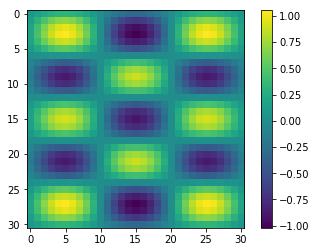

In [76]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

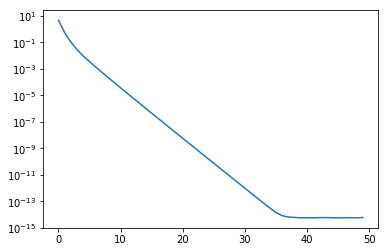

In [77]:
plt.semilogy(GMM_Res)

**Calculate Spectral Radius**

In [78]:
GMM_Radius = rho(inputsize,A1,P,R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.4540814883789567


## AMG

**Define Solver and Solve**

In [81]:
amg_solver = pyamg.classical.classical.ruge_stuben_solver(A1,max_levels = 2)
pyamg.relaxation.smoothing.change_smoothers(amg_solver,presmoother=("jacobi", {"omega": w, "iterations": s}),postsmoother=("jacobi", {"omega": w, "iterations": s}))
AMG_Res = []
print(amg_solver)
AMG_U= amg_solver.solve(RightF, maxiter = MAX_ITER, tol=0, residuals=AMG_Res,cycle='V')

D:\anaconda\lib\site-packages\pyamg\classical\classical.py:101: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


multilevel_solver
Number of Levels:     2
Operator Complexity:  1.872
Grid Complexity:      1.501
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          961         4681 [53.42%]
    1          481         4081 [46.58%]



**Plot Result**

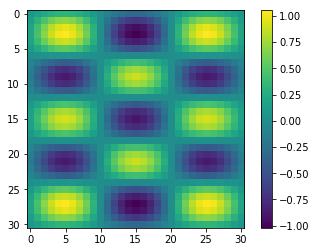

In [82]:
plt.imshow(AMG_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

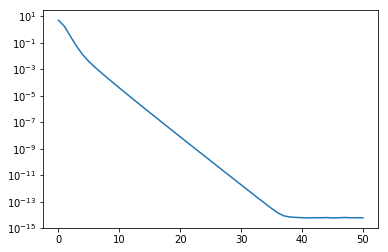

In [83]:
plt.semilogy(AMG_Res)

## DMM

**Optimize R, P, $\omega$**

In [15]:
Pnew, Rnew, wnew, Rhoold, Rhonew = homotopy_optimizer_GD(inputsize, A0, A1, P, R, w, s, learning_rate = 1e-1 ,accept_radius = GMM_Radius,step_length = 1e-1)

======Section 1======
L = 0.2
rho = 0.40683848899974795
L = 0.30000000000000004
rho = 0.3681483422479439
L = 0.4
rho = 0.41296989403114664
L = 0.5
rho = 0.37036927560767113
Decrease the step_length, learning_rate and Restart!!
step_length = 0.010000000000000002
learning_rate = 0.010000000000000002
rhonew = 0.5221368583983736
L = 0.020000000000000004
rho = 0.4492335460425738
L = 0.030000000000000006
rho = 0.44444051376647414
L = 0.04000000000000001
rho = 0.43970166951523326
L = 0.05000000000000001
rho = 0.4350163050783652
L = 0.06000000000000001
rho = 0.4303837256038059
L = 0.07
rho = 0.42580324915625584
L = 0.08000000000000002
rho = 0.4212742062986168
L = 0.09000000000000002
rho = 0.41679593969491313
L = 0.10000000000000003
rho = 0.412367803733231
L = 0.11000000000000004
rho = 0.4079891641673205
L = 0.12000000000000005
rho = 0.4036593977756338
L = 0.13000000000000006
rho = 0.3993778920366646
L = 0.14000000000000007
rho = 0.39514404481955945
L = 0.15000000000000008
rho = 0.3909572640893

**Calculate Result and Residual**

In [16]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1, RightF, Pnew, Rnew, s, wnew, MAX_ITER)

Residual = 4.560692539550361
Interation = 0
Residual = 0.3081525084084382
Interation = 1
Residual = 0.04680201017045223
Interation = 2
Residual = 0.01120990675464083
Interation = 3
Residual = 0.003238448041258838
Interation = 4
Residual = 0.0009885186564109656
Interation = 5
Residual = 0.0003092086984012285
Interation = 6
Residual = 9.821330988912395e-05
Interation = 7
Residual = 3.154158908687414e-05
Interation = 8
Residual = 1.021558102157286e-05
Interation = 9
Residual = 3.330666157628309e-06
Interation = 10
Residual = 1.0917288886691633e-06
Interation = 11
Residual = 3.5939870291123667e-07
Interation = 12
Residual = 1.1873391958475291e-07
Interation = 13
Residual = 3.9340505708675805e-08
Interation = 14
Residual = 1.3066426500327795e-08
Interation = 15
Residual = 4.348632672445184e-09
Interation = 16
Residual = 1.4497331186150645e-09
Interation = 17
Residual = 4.840042344330012e-10
Interation = 18
Residual = 1.617869141904152e-10
Interation = 19
Residual = 5.413693090417719e-11
Int

**Plot Result**

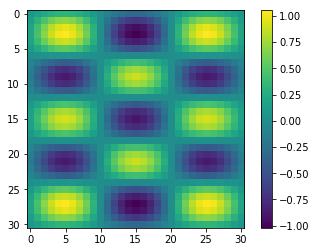

In [17]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

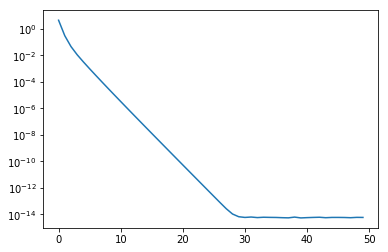

In [18]:
plt.semilogy(DMM_Res)

**Calculate Spectral Radius**

In [19]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.3667135587920317


## Compare

In [20]:
print('GMM_Radius = {}'.format(GMM_Radius))
print('DMM_Radius = {}'.format(DMM_Radius))
print("GMM_Radius : DMM_Radius = 1 : %f" %(DMM_Radius/GMM_Radius))

GMM_Radius = 0.4540814883789567
DMM_Radius = 0.3667135587920317
GMM_Radius : DMM_Radius = 1 : 0.807594


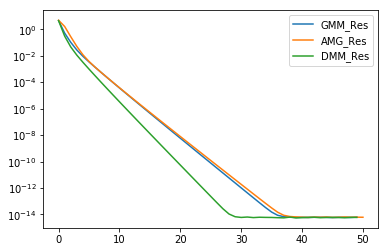

In [84]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(AMG_Res, label = 'AMG_Res')
plt.semilogy(DMM_Res, label = 'DMM_Res')
plt.legend(loc='upper right')

In [22]:
print('omega after optimization = {}'.format(wnew))

omega after optimization = 0.8001403284003551


P after optimization 


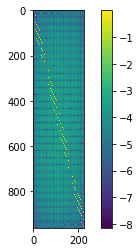

In [23]:
print('P after optimization ')
plt.imshow(np.log10(np.abs(Pnew)))
plt.colorbar()

R after optimization 


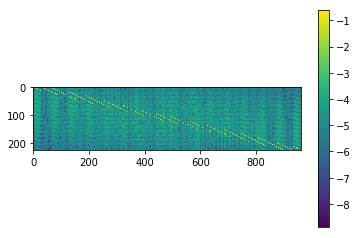

In [24]:
print('R after optimization ')
plt.imshow(np.log10(np.abs(Rnew)))
plt.colorbar()

P under log10(abs())


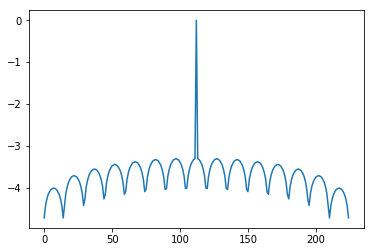

In [25]:
print("P under log10(abs())")
plt.plot(np.log10(np.abs(Pnew))[round(0.5*inputsize)][:])

R under log10(abs())


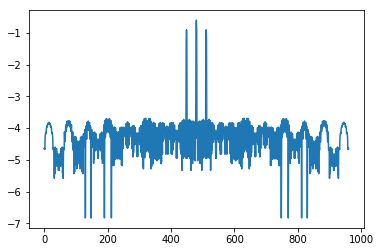

In [26]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[:][round(0.5*outputsize)])

In [27]:
import win32com.client
import winsound
speak = win32com.client.Dispatch('SAPI.SPVOICE')
speak.Speak('The program has finished, please check the result')

1